#This Notebook contains the first runthrough.


In [1]:
!git clone https://github.com/bahducoup/nlptrading.git

Cloning into 'nlptrading'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 47 (delta 19), reused 33 (delta 10), pack-reused 0
Unpacking objects: 100% (47/47), done.


#There are 2 ways of downloading the data.

### To use kaggle follow the following steps

1. Go to your account, Scroll to API section and Click Expire API Token to remove previous tokens

2. Click on Create New API Token - It will download kaggle.json file on your machine.

3. In the next step, upload that 'kaggle.json' file

### Otherwise Download from google storage



In [ ]:
from google.colab import files
import matplotlib.pyplot as plt

files.upload()

In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download paultimothymooney/stock-market-data
! unzip stock-market-data.zip
! mv stock_market_data nlptrading/dataset/stock_market_data

We need to create a dataset where: \\
  X contains:

1.   the 10 last OWL_CVs
2.   10 weeks of wednesday OWL_CVs
3.   Open
3.   Month
4.   Day of Week
  
Y contains:

1.   High, Low, Volume, Close
2.   2 (tomorrow), 3, 4, 5, 6, 7, 8 (Week from now), OWL_CVs \\
  a. Note: 2 High will be max of 1 High and 2 High \\
  b. Same with Low
3.   Month OWL_CV
4.   3 Month OWL_CV

Processing the different exchanges:


1.   Keep track of stocks we've seen
2.   If there is a new stock, add it to the table
3.   For each row, store the stock symbol


Possible Errors

* Stocks might be repeated in different exchanges under different names
* Stocks might have different information in different exchanges




Start Cleaning Data



1.   Remove rows where a stock wasn't traded (Volume = 0)
2.   Remove rows that were Nan Values
3.   Keep only the stocks that have .99 percent of the data

  3.1 We keep 2152 / 3538 stocks (4/7) and they are clean



In [ ]:
#to run processing of python files, run this command:
from nlptrading.src.preprocessing.kaggle import process_owlcv_kaggle
process_owlcv_kaggle()

Abberviation: OWL_CV (Open, High, Low, Close, Volume)

In [2]:
from google.colab import auth
auth.authenticate_user()

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'nlptrading'
!gcloud config set project {project_id}

Updated property [core/project].


The Next section uploads the datasets to Google Storage. As such it is commented out

In [3]:
# import uuid
# # Make a unique bucket to which we'll upload the file.
# # (GCS buckets are part of a single global namespace.)
# bucket_name = 'nlptrading-dataset'

# # Full reference: https://cloud.google.com/storage/docs/gsutil/commands/mb
# !gsutil mb gs://{bucket_name}

# # Copy the file to our new bucket.
# # Full reference: https://cloud.google.com/storage/docs/gsutil/commands/cp
# !gsutil -o GSUtil:parallel_composite_upload_threshold=150M  cp test_df.csv gs://{bucket_name}/
# !gsutil -o GSUtil:parallel_composite_upload_threshold=150M  cp train_df.csv gs://{bucket_name}/
  
# # Finally, dump the contents of our newly copied file to make sure everything worked.
# #!gsutil cat gs://{bucket_name}/to_upload.txt

Uncomment out the next sections to download the files form Google Storage 

In [4]:
# bucket_name = 'nlptrading-dataset'
# !gsutil cp gs://{bucket_name}/test_df.csv test_df.csv
# !gsutil cp gs://{bucket_name}/train_df.csv train_df.csv
# !mv train_df.csv nlptrading/dataset/train_df.csv
# !mv test_df.csv nlptrading/dataset/test_df.csv

Copying gs://nlptrading-dataset/test_df.csv...
- [1 files][384.5 MiB/384.5 MiB]                                                
Operation completed over 1 objects/384.5 MiB.                                    
Copying gs://nlptrading-dataset/train_df.csv...
/ [1 files][882.5 MiB/882.5 MiB]   72.6 MiB/s                                   
Operation completed over 1 objects/882.5 MiB.                                    


In [5]:
import pandas as pd

In [6]:
train_df = pd.read_csv('nlptrading/dataset/train_df.csv', index_col=0)
train_df['Date'] = pd.to_datetime(train_df['Date'])

test_df = pd.read_csv('nlptrading/dataset/test_df.csv', index_col=0)
test_df['Date'] = pd.to_datetime(test_df['Date'])

Creating New Features



1.   Percentage Increase
2.   Percentage High, Low
3.   Day of Week



In [7]:
train_df['Return'] = 1 + (train_df.Close - train_df.Open)/train_df.Open
train_df['Day_of_week'] = train_df['Date'].dt.weekday
train_df = pd.concat([train_df,pd.get_dummies(train_df.Day_of_week, prefix='weekday')], axis=1)

test_df['Return'] = 1 + (test_df.Close - test_df.Open)/test_df.Open
test_df['Day_of_week'] = test_df['Date'].dt.weekday
test_df = pd.concat([test_df,pd.get_dummies(test_df.Day_of_week, prefix='weekday')], axis=1)

train_df

,Date,Low,Open,Volume,High,Close,Adjusted Close,Symbol,Return,Day_of_week,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4
0,1990-06-28,9.968750,10.093750,176400.0,10.093750,9.968750,2.215101,RIO,0.987616,3,0,0,0,1,0
1,1990-06-29,10.000000,10.031250,69200.0,10.062500,10.062500,2.235931,RIO,1.003115,4,0,0,0,0,1
2,1990-07-02,10.000000,10.000000,62000.0,10.031250,10.031250,2.228988,RIO,1.003125,0,1,0,0,0,0
3,1990-07-03,10.031250,10.031250,29600.0,10.062500,10.062500,2.235931,RIO,1.003115,1,0,1,0,0,0
4,1990-07-05,9.656250,9.718750,31200.0,9.718750,9.687500,2.152606,RIO,0.996785,3,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18936070,2015-12-24,71.940002,71.949997,243800.0,72.570000,72.349998,67.721214,MSCI,1.005559,3,0,0,0,1,0
18936071,2015-12-28,71.769997,72.169998,444300.0,72.449997,72.379997,67.749298,MSCI,1.002910,0,1,0,0,0,0
18936072,2015-12-29,72.330002,72.760002,266800.0,73.379997,72.849998,68.189255,MSCI,1.001237,1,0,1,0,0,0
18936073,2015-12-30,72.489998,72.660004,245200.0,73.440002,72.589996,67.945869,MSCI,0.999037,2,0,0,1,0,0


In [8]:
import pandas as pd
from sklearn import preprocessing

#This contains processing that gets applied to the data to keep distributiosn similar in the inputs
#It will get refactored to src as well
sing_fact_scale = ['Open','Low','High','Close','Adjusted Close'] #Note there should be other features that do this stock dependent
cols_to_scale = ['Volume']
train_open_mean = train_df['Open'].mean()
train_df[sing_fact_scale] = train_df[sing_fact_scale] / train_open_mean
x = train_df[cols_to_scale].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
train_df[cols_to_scale] = x_scaled

test_df[sing_fact_scale] = test_df[sing_fact_scale] / train_open_mean #Replicating what was 
x = test_df[cols_to_scale].values #returns a numpy array
x_scaled = min_max_scaler.transform(x)
test_df[cols_to_scale] = x_scaled

train_df

,Date,Low,Open,Volume,High,Close,Adjusted Close,Symbol,Return,Day_of_week,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4
0,1990-06-28,0.078766,0.079754,0.000024,0.079754,0.078766,0.017502,RIO,0.987616,3,0,0,0,1,0
1,1990-06-29,0.079013,0.079260,0.000009,0.079507,0.079507,0.017667,RIO,1.003115,4,0,0,0,0,1
2,1990-07-02,0.079013,0.079013,0.000008,0.079260,0.079260,0.017612,RIO,1.003125,0,1,0,0,0,0
3,1990-07-03,0.079260,0.079260,0.000004,0.079507,0.079507,0.017667,RIO,1.003115,1,0,1,0,0,0
4,1990-07-05,0.076297,0.076791,0.000004,0.076791,0.076544,0.017008,RIO,0.996785,3,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18936070,2015-12-24,0.568418,0.568497,0.000033,0.573396,0.571657,0.535084,MSCI,1.005559,3,0,0,0,1,0
18936071,2015-12-28,0.567075,0.570235,0.000060,0.572447,0.571894,0.535306,MSCI,1.002910,0,1,0,0,0,0
18936072,2015-12-29,0.571499,0.574897,0.000036,0.579796,0.575608,0.538782,MSCI,1.001237,1,0,1,0,0,0
18936073,2015-12-30,0.572764,0.574107,0.000033,0.580270,0.573554,0.536859,MSCI,0.999037,2,0,0,1,0,0


In [9]:
train_val_split = int(len(train_df)*.8)
#TODO Improve the splits
val_df = train_df[train_val_split:]
train_df = train_df[:train_val_split]

In [10]:
from nlptrading.src.models.LSTM import LSTMModel

In [11]:

config = {
    # "alpha_vantage": {
    #     "key": "YOUR_API_KEY", # Claim your free API key here: https://www.alphavantage.co/support/#api-key
    #     "symbol": "IBM",
    #     "outputsize": "full",
    #     "key_adjusted_close": "5. adjusted close",
    # },
    # "data": {
    #     "window_size": 20,
    #     "train_split_size": 0.80,
    # }, 
    # "plots": {
    #     "show_plots": True,
    #     "xticks_interval": 90,
    #     "color_actual": "#001f3f",
    #     "color_train": "#3D9970",
    #     "color_val": "#0074D9",
    #     "color_pred_train": "#3D9970",
    #     "color_pred_val": "#0074D9",
    #     "color_pred_test": "#FF4136",
    # },
    "model": {
        "input_size": 6, # since we are only using 6 features, close price
        "static_input_size": 2,
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cuda", # "cuda" or "cpu"
        #"device": xm.xla_device(),
        "batch_size": 64,
        "num_epoch": 5,
        "learning_rate": 0.001,
        "scheduler_step_size": 40,
    }
}

In [12]:
model = LSTMModel(input_size=config["model"]["input_size"], 
                  static_input_size=config["model"]["static_input_size"], 
                  hidden_layer_size=config["model"]["lstm_size"], 
                  num_layers=config["model"]["num_lstm_layers"], 
                  output_size=1, 
                  dropout=config["model"]["dropout"])
model = model.to(config["training"]["device"])

In [14]:
import torch.optim as optim
from torch import nn

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)

In [15]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0
    temp_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x1, x2, y) in enumerate(tqdm(dataloader)):
        if is_training:
            optimizer.zero_grad()

        batchsize = x1.shape[0]

        x1 = x1.to(config["training"]["device"])
        x2 = x2.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model(x1,x2)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()
          
        epoch_loss += (loss.detach().item() / batchsize)
        temp_loss += (loss.detach().item() / batchsize)

        if(idx%10000 == 9999):
          print(temp_loss / 10000)
          temp_loss = 0 #TODO: Connect with wandb


    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

In [22]:
from tqdm import tqdm
import torch

def predict(dataloader):
  predictions = []
  actuals = []
  optimizer.zero_grad()
  model.eval()

  for idx, (x1, x2, y) in enumerate(tqdm(dataloader)):
    batchsize = x1.shape[0]

    x1 = x1.to(config["training"]["device"])
    x2 = x2.to(config["training"]["device"])
    y = y.to(config["training"]["device"])

    out = model(x1,x2)
    predictions.append(out.detach())
    actuals.append(y)
  return torch.cat(predictions).cpu(), torch.cat(actuals).cpu()

In [23]:
from nlptrading.src.dataloaders.stock_price import get_loader

train_dataloader = get_loader(train_df, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = get_loader(val_df, batch_size=config["training"]["batch_size"], shuffle=True)
test_dataloader = get_loader(test_df, batch_size=config["training"]["batch_size"], shuffle=False)

In [19]:
print(len(train_df)/config['training']['batch_size'])

103373.328125


In [ ]:
# begin training
# Takes like 10 min to run an epoch w a GPU
for epoch in range(config["training"]["num_epoch"]):
    print('training')
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    print('validating')
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()

    t_loss = loss_train/len(train_df)*config['training']['batch_size']
    v_loss = loss_val/len(val_df)*config['training']['batch_size']

    print('Epoch[{}/{}] | loss train:{:.6f}, val:{:.6f} | lr:{:.6f}'
              .format(epoch+1, config["training"]["num_epoch"], t_loss, v_loss, lr_train))

In [ ]:
pred, actual = predict(test_dataloader) #takes a min and a half

 26%|██▌       | 13409/51921 [00:18<00:53, 718.34it/s]

Notice that the plot shows all of the predictions to be clumped closely together

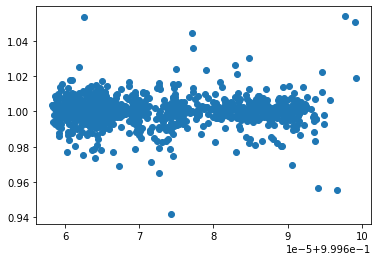

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(pred[-1000:],actual[-1000:])